In [243]:
# General-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Utility and preprocessing
from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn - preprocessing, modeling, evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score

# XGBoost
import xgboost as xgb

# Deep learning - TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, GRU, Dense, Activation, Dropout, Embedding,
                                     BatchNormalization, GlobalMaxPooling1D, Conv1D,
                                     MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [244]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [245]:
"""Missing values"""
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [246]:
"""Extracting Text Featurs"""

text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [247]:
"""Catagorical Feature"""
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


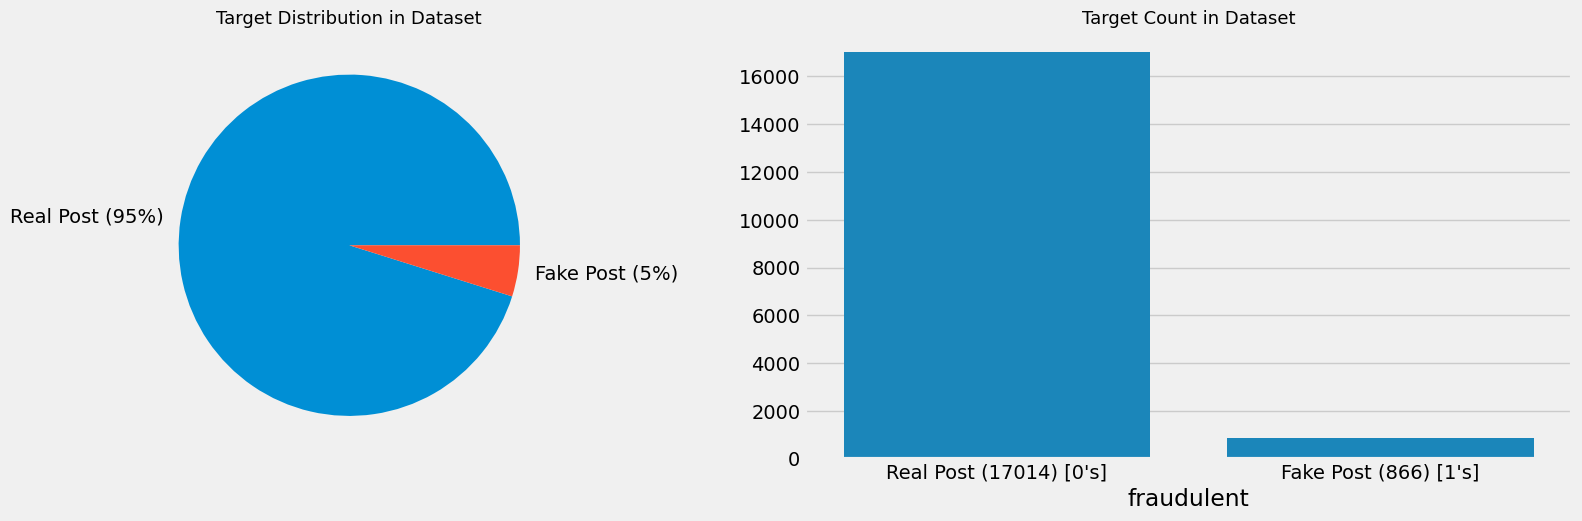

In [248]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(x=temp.index, y=temp.values, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

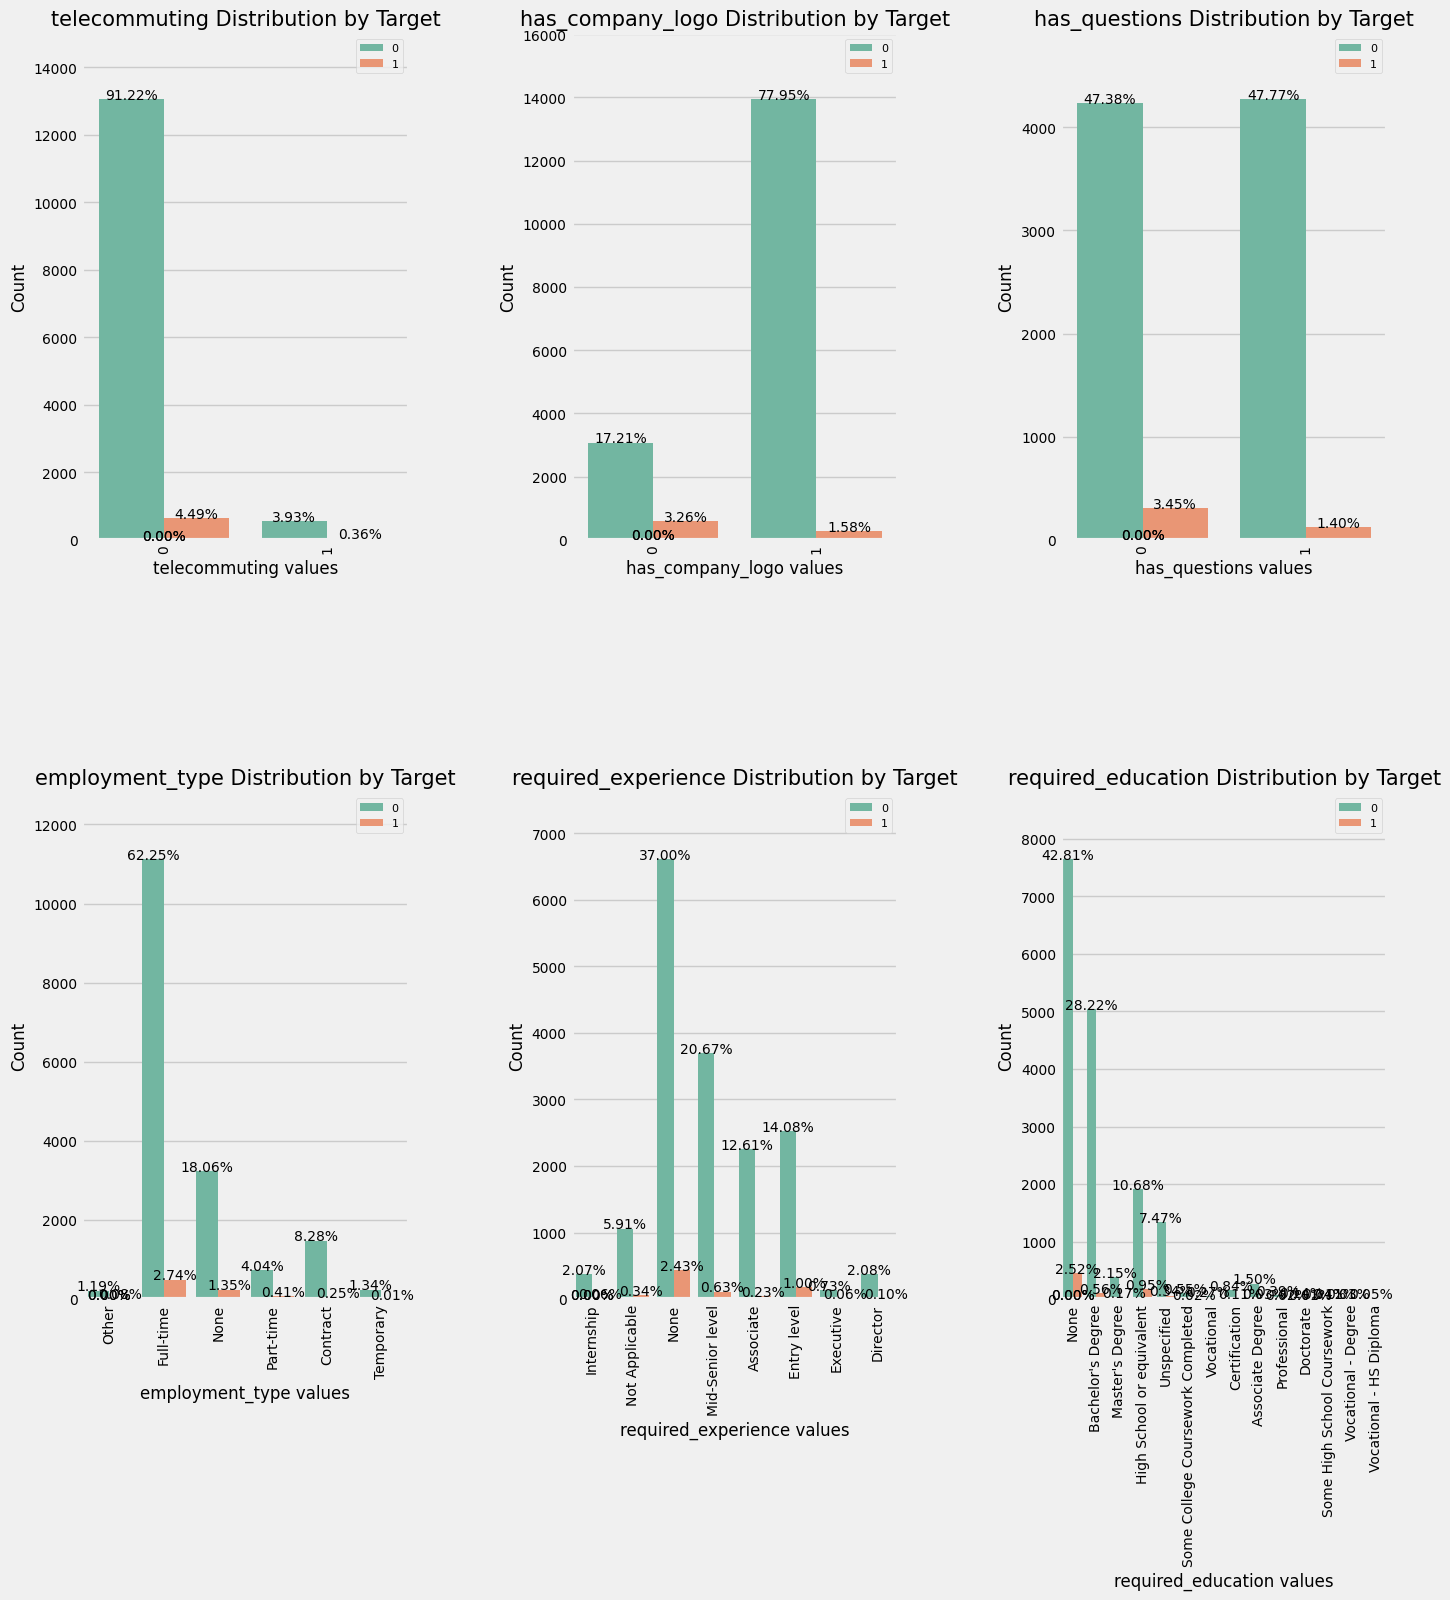

In [249]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()

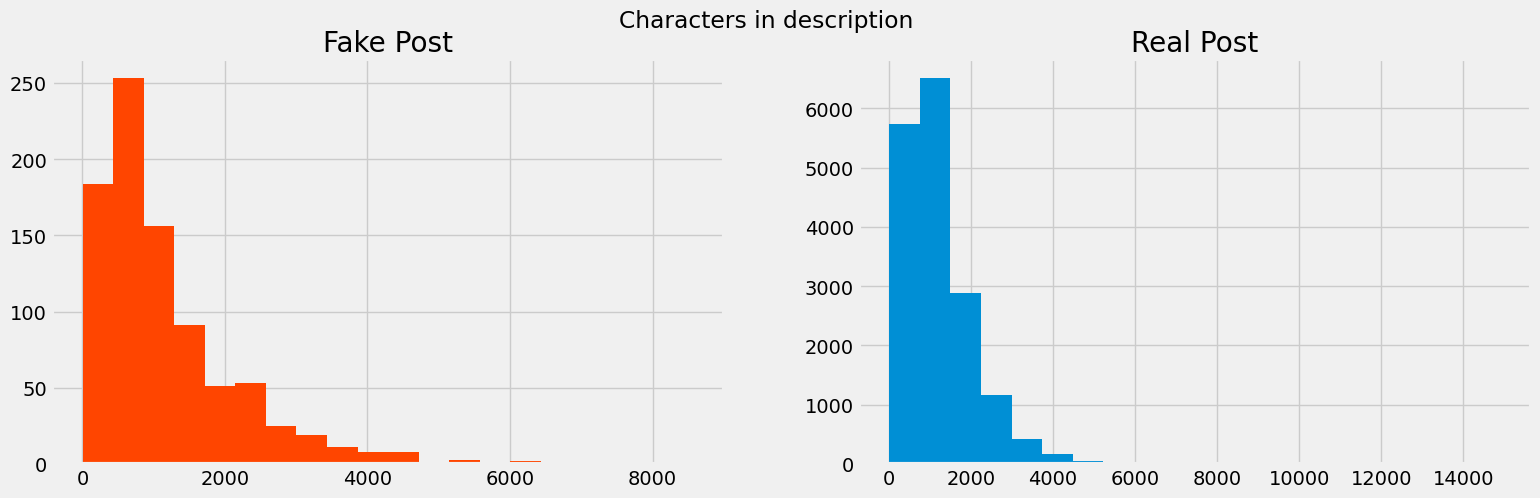

In [250]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

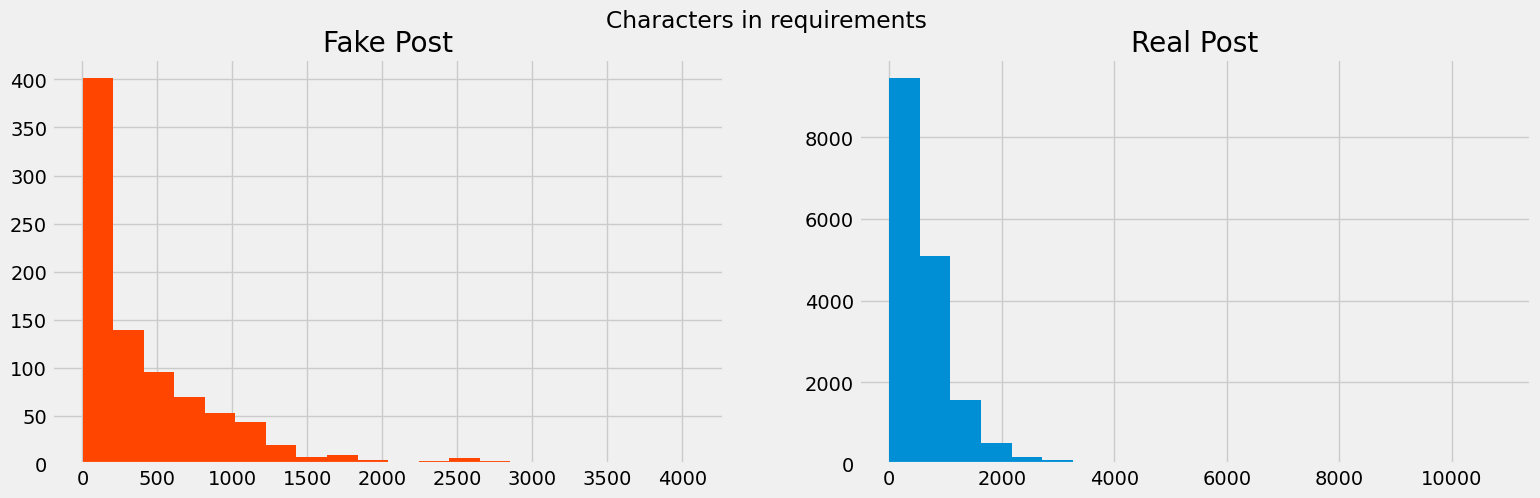

In [251]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

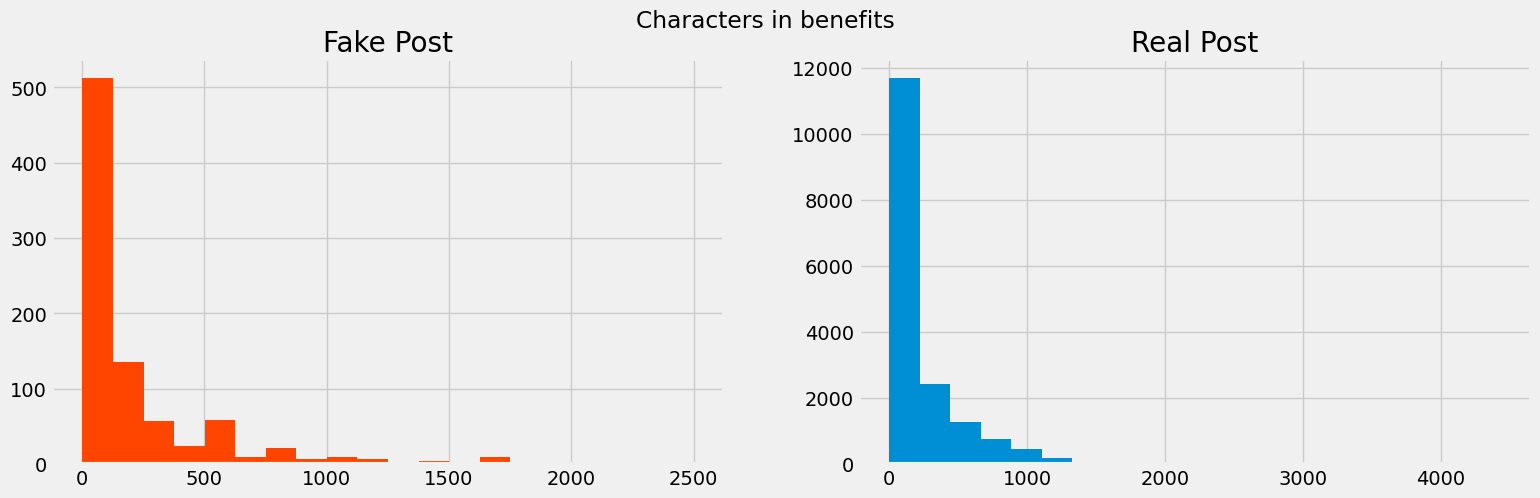

In [252]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

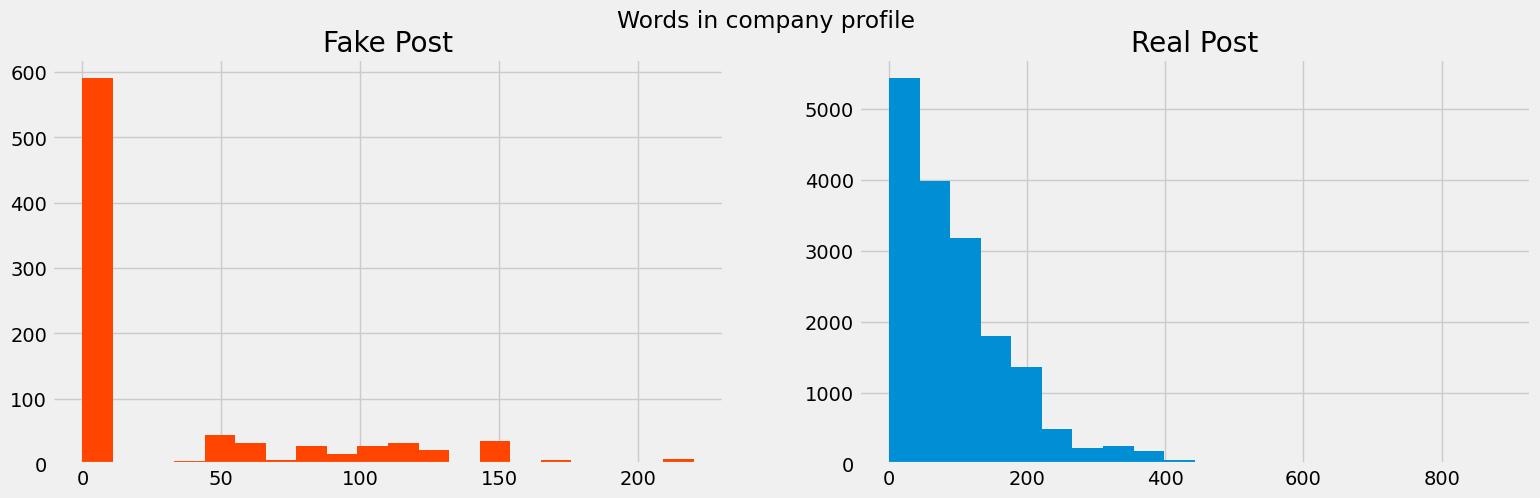

In [253]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

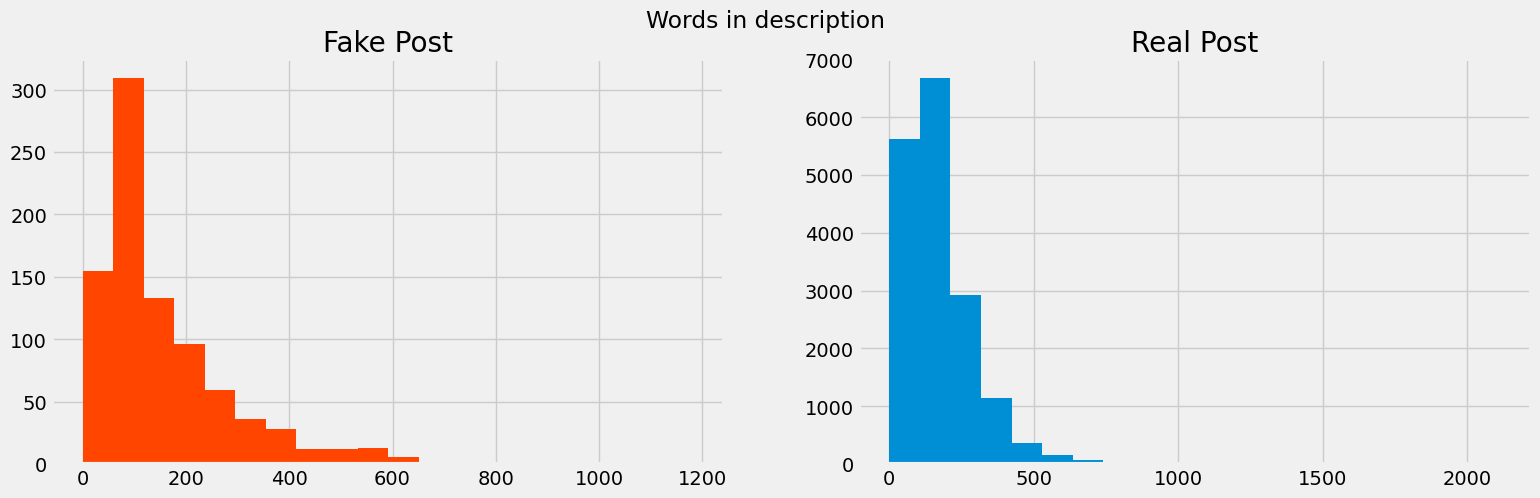

In [254]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in description')
plt.show()

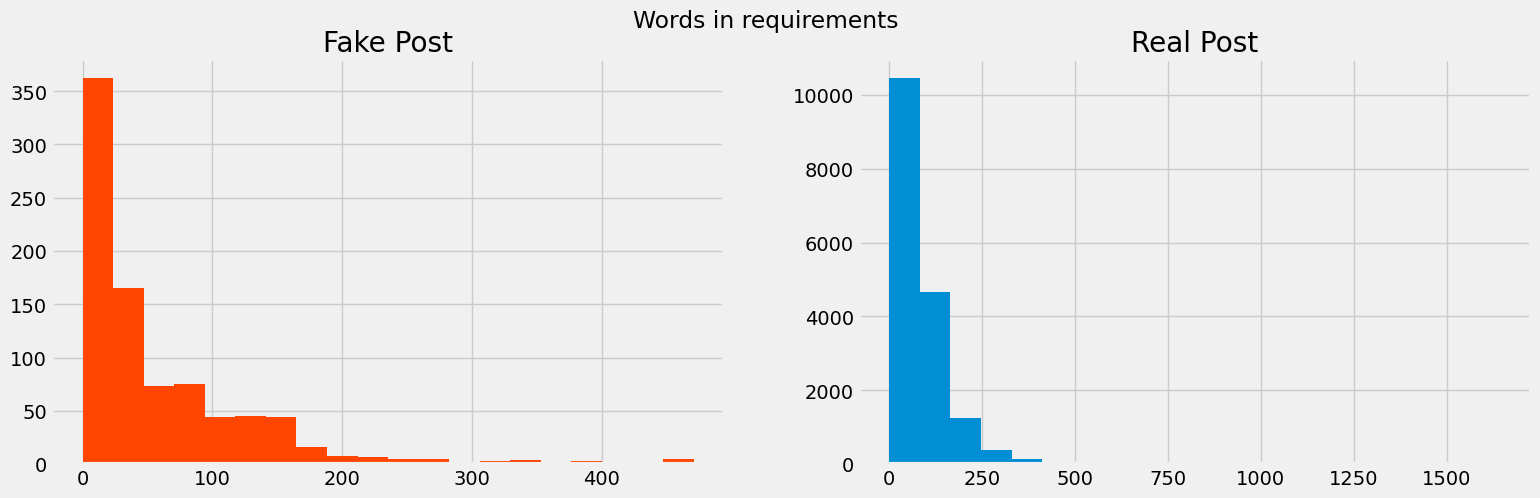

In [255]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in requirements')
plt.show()

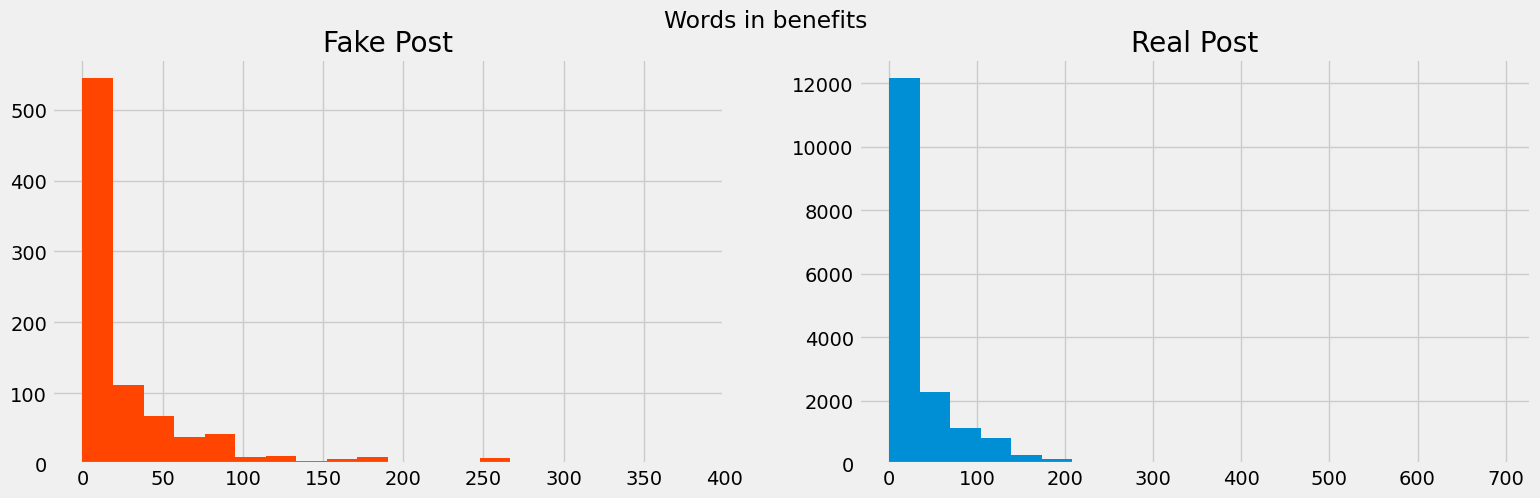

In [256]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in benefits')
plt.show()

In [257]:
"""Concate the text data for preprocessing and modeling"""
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


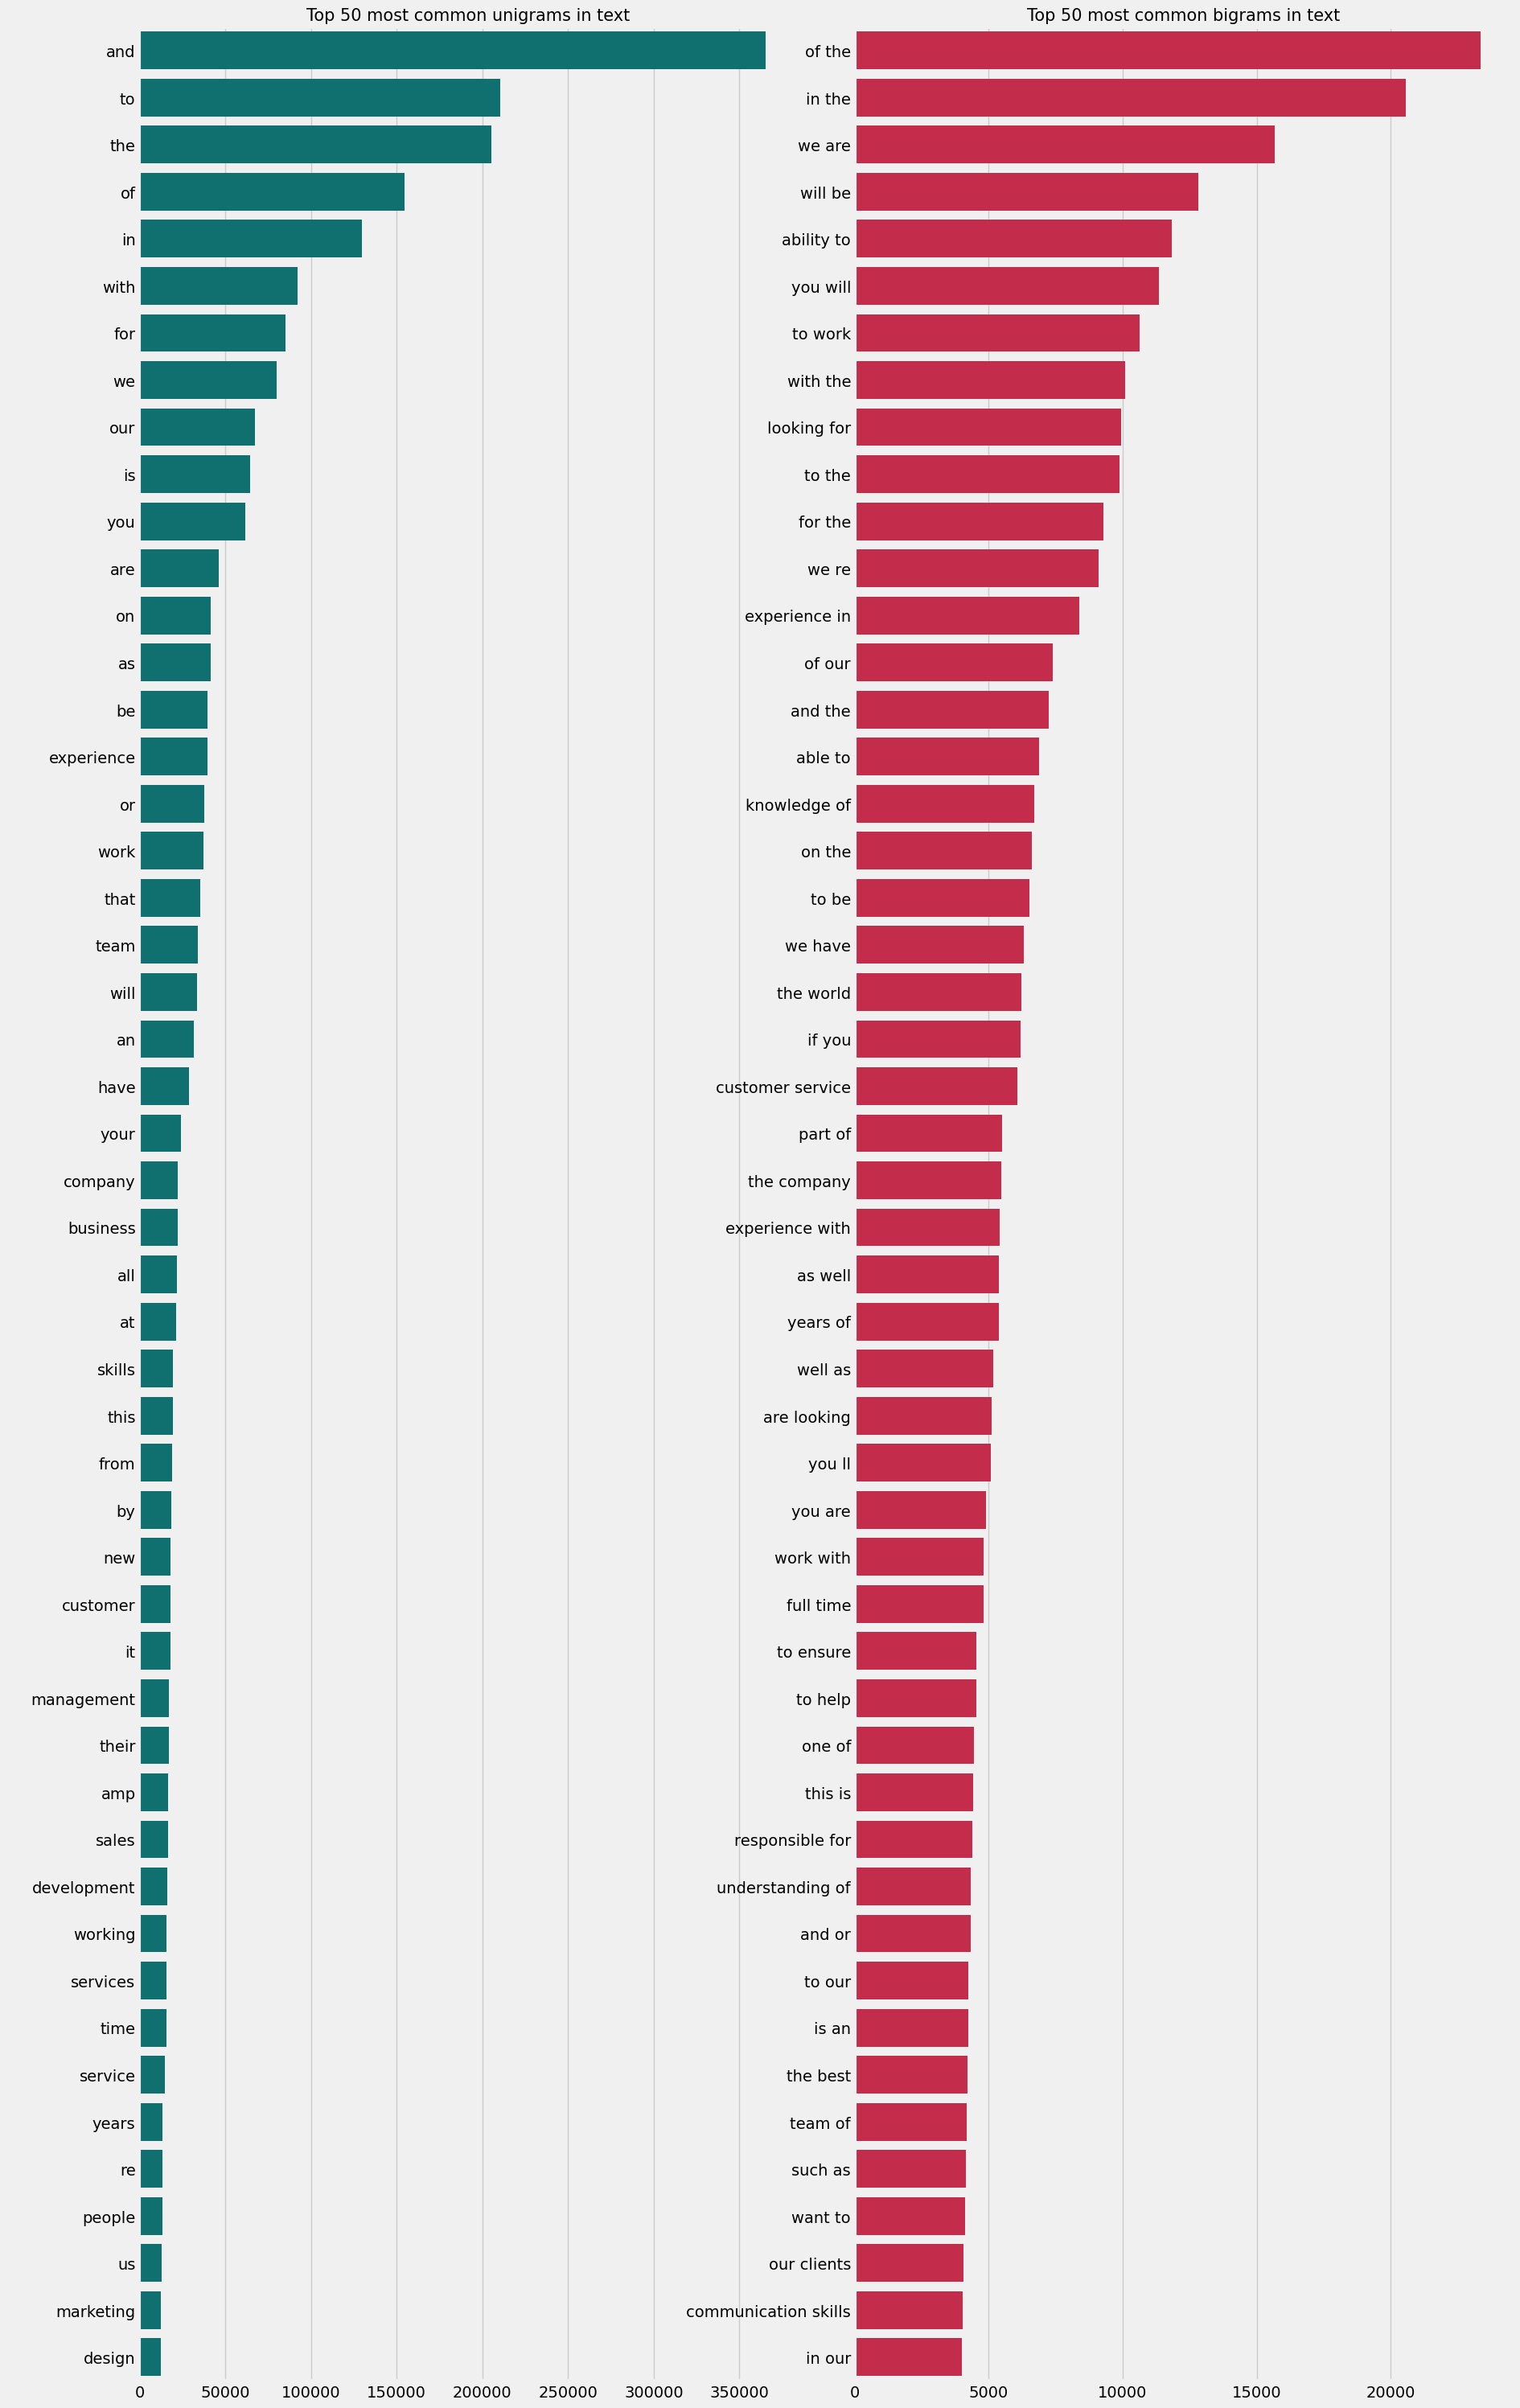

In [258]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

In [259]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(3)

CPU times: total: 7.91 s
Wall time: 7.97 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [260]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

CPU times: total: 2.09 s
Wall time: 2.09 s


0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
dtype: object

In [261]:
%%time
stop_words = stopwords.words('english')
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stop_words]
    return words


text = text.apply(lambda x : remove_stopwords(x))

CPU times: total: 15.6 s
Wall time: 15.9 s


In [262]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x : combine_text(x))
text.head(3)

CPU times: total: 250 ms
Wall time: 247 ms


0    marketing internwere weve created groundbreaki...
1    customer service cloud video seconds worlds cl...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [263]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = []   
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text[train_ix], text[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]

    # Appling Count Vectorizer
    count_vectorizer = CountVectorizer()
    train_X_vec = count_vectorizer.fit_transform(train_X)
    test_X_vec = count_vectorizer.transform(test_X)    
    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
    lr.fit(train_X_vec, train_y)
    preds = lr.predict(test_X_vec)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1
0 AUC: 0.8457923049876087
Fold 2
1 AUC: 0.8517195809885532
Fold 3
2 AUC: 0.8283043353450458
Fold 4
3 AUC: 0.8720977240415205
Fold 5
4 AUC: 0.8611871313020738
AUC mean score = 0.851820
AUC std score = 0.014753


In [264]:
# spliting tthe data for glove
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.2, random_state=4, stratify=target)

In [265]:
"""Load the Glove vectors in a dictionay"""
embeddings_index={}
with open('D:\My Files\Practice Projects\Fake Job Posting Prediction/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embeddings_index[word]=vectors
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [266]:
""" Function Creates a normalized vector for the whole sentence"""
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

In [267]:
import nltk
nltk.download('punkt')  # Standard tokenizers
nltk.download('punkt_tab')  # The specific resource you need


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shivh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shivh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [268]:
# create glove features
xtrain_glove = np.array([sent2vec(x) for x in tqdm(X_train)])
xtest_glove = np.array([sent2vec(x) for x in tqdm(X_test)])

100%|██████████| 3576/3576 [00:15<00:00, 233.24it/s]


In [269]:
"""scale the data before any neural net"""
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [270]:
model = Sequential()

model.add(Dense(200, input_dim=200, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [271]:
model.fit(xtrain_glove_scl, y=y_train, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xtest_glove_scl, y_test))

Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7263 - loss: 0.5630 - val_accuracy: 0.9628 - val_loss: 0.1377
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9507 - loss: 0.1675 - val_accuracy: 0.9701 - val_loss: 0.1065
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9629 - loss: 0.1228 - val_accuracy: 0.9737 - val_loss: 0.0975
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9685 - loss: 0.0982 - val_accuracy: 0.9760 - val_loss: 0.0919
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9702 - loss: 0.0870 - val_accuracy: 0.9748 - val_loss: 0.0946
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9735 - loss: 0.0770 - val_accuracy: 0.9760 - val_loss: 0.0920
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9784 - loss: 0.0668 - val_accuracy: 0.9771 - val_loss: 0.0913
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9796 - loss: 0.0612 - val_accura

In [272]:
predictions = model.predict(xtest_glove_scl)
predictions = np.round(predictions).astype(int)
print('2 layer sequential neural net on GloVe Feature')
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
2 layer sequential neural net on GloVe Feature
AUC score : 0.84227


In [273]:
new_text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

In [274]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
new_text = new_text.apply(lambda x: clean_text(x))
new_text.head(3)

CPU times: total: 15.8 s
Wall time: 15.9 s


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [275]:
# Trying First 2000 sample
batch_1 = new_text[:2000]
target_1 = target[:2000]
target_1.value_counts()

fraudulent
0    1948
1      52
Name: count, dtype: int64

In [276]:
# importing the tools 
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [277]:
# DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [278]:
%%time
# Tokenization
tokenized = batch_1.apply((lambda x: tokenizer.encode(x, max_length = 60, add_special_tokens=True)))
tokenized.shape

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: total: 49.9 s
Wall time: 50.2 s


(2000,)

In [279]:
# Padding ==> convert 1D array to 2D array
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(2000, 60)

In [280]:
# Masking ==>  ignore (mask) the padding we've added
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 60)

In [281]:
# Deep Learning
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

last_hidden_states[0].shape

torch.Size([2000, 60, 768])

In [282]:
features = last_hidden_states[0][:,0,:].numpy()
labels = target_1

In [283]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
# train default para
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [284]:
predictions = lr_clf.predict(test_features)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))

AUC score : 0.79897
